In [26]:
pip install numpy pandas seaborn matplotlib scikit-learn torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


 ## **Importing Modules and Libraries**

In [49]:
# importing required libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from os import path
import os
import json

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn import metrics
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

 ### Cek ketersediaan GPU

In [28]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU


 ## **Importing Datasets**

In [29]:
# Membaca dataset
ctu_attack = pd.read_csv('./Dataset/CTU13_Attack_Traffic.csv')
ctu_normal = pd.read_csv('./Dataset/CTU13_Normal_Traffic.csv')
unsw_data = pd.read_csv('./Dataset/UNSW_NB15_training-set.csv')

# Menambahkan label untuk klasifikasi
ctu_attack['label'] = 'ransomware'
ctu_normal['label'] = 'normal'

# Mapping label 0 dan 1 pada UNSW-NB15 ke 'normal' dan 'ransomware'
unsw_data['label'] = unsw_data['label'].replace({0: 'normal', 1: 'ransomware'})

# Menggabungkan ketiga dataset
data = pd.concat([ctu_attack, ctu_normal, unsw_data], ignore_index=True)

In [30]:
data.head(n=5)

,Unnamed: 0,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.0,59086131.0,7.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,12452268.0,37.0,1.0,2408.0,68.0,68.0,50.0,65.081081,6.726310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,118741070.0,5.0,4.0,170.0,682.0,45.0,22.0,34.000000,10.440307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,180643.0,25.0,11.0,180.0,25790.0,90.0,0.0,7.200000,24.919872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,440.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Dimensions of the datasets
print("(rows, columns):", data.shape)

(rows, columns): (267553, 104)


#### Drop '-' pada kolom service

In [32]:
if 'service' in data.columns:
    print("\nService Distribution in Training Data:")
    print(data['service'].value_counts())


Service Distribution in Training Data:
service
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: count, dtype: int64


In [33]:
# Menghapus nilai "-" dari data
data = data[data['service'] != '-']

In [34]:
# Dimensions of the datasets after drop '-' in service column
print("(rows, columns):", data.shape)

(rows, columns): (173385, 104)


 ## **Data Visualization**

Class distribution: ransomware vs normal:
label
ransomware    100583
normal         72802
Name: count, dtype: int64


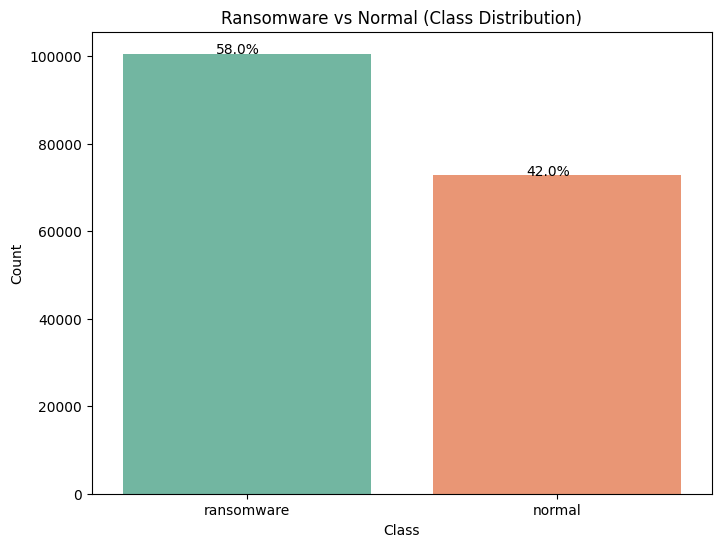

In [35]:
if 'label' in data.columns:
    print("Class distribution: ransomware vs normal:")
    class_counts = data['label'].value_counts()
    print(class_counts)

    # Plot the distribution of classes
    plt.figure(figsize=(8, 6))

    ax = sns.countplot(data=data, x='label', hue='label', order=class_counts.index, palette='Set2', legend=False)
    plt.xticks(rotation=0)
    plt.title('Ransomware vs Normal (Class Distribution)')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Add percentages on top of the bars
    total = len(data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 5
        ax.annotate(percentage, (x, y))

    # Save the figure
    plt.savefig('./Visualisasi/label_bar_chart.png')

    # Show the figure
    plt.show()

 ## **Data Preprocessing**

In [36]:
# Data Preprocessing
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [37]:
# Mengidentifikasi kolom numerik secara otomatis
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Menghapus kolom 'id' dan target label 'label' dari daftar kolom numerik
if 'id' in numerical_cols:
    numerical_cols.remove('id')
if 'label' in numerical_cols:
    numerical_cols.remove('label')

# Normalisasi kolom numerik
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

 ## **Label Encoding**

In [38]:
# Encode binary labels
bin_data = data.copy()
bin_data['label'] = bin_data['label'].apply(lambda x: 'ransomware' if x == 1 else 'normal')
le = preprocessing.LabelEncoder()
bin_data['label'] = le.fit_transform(bin_data['label'])

bin_data.fillna(0, inplace=True)

 ## **Data Splitting**

In [39]:
# Define features and target variable
X_train = bin_data.drop(columns=['id','label'])
y_train = bin_data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [40]:
# Convert the dataset to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)     
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)    
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long) 

### Gunakan CUDA GPU untuk model

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## **Classification without Tuning**

#### Karena data cukup besar dan kompleks, maka kami menggunakan Fold 10, Epoch 20 dan default hyperparameters: num_heads=8, embed_dim=256, dropout=0.1, lr=0.001, batch_size=32

Using default hyperparameters: num_heads=8, embed_dim=256, dropout=0.1, lr=0.001, batch_size=32
Fold 1/5
Epoch 1/3: Training Loss: 0.5051, Validation Loss: 0.6871, Accuracy: 57.79%, F1 Score: 0.4268
Saved best model for fold 1 at epoch 1.
Epoch 2/3: Training Loss: 0.5153, Validation Loss: 0.6865, Accuracy: 58.75%, F1 Score: 0.4498
Saved best model for fold 1 at epoch 2.
Epoch 3/3: Training Loss: 0.6548, Validation Loss: 0.6062, Accuracy: 67.01%, F1 Score: 0.6133
Saved best model for fold 1 at epoch 3.
Fold 2/5
Epoch 1/3: Training Loss: 0.3627, Validation Loss: 0.2566, Accuracy: 91.45%, F1 Score: 0.9150
Saved best model for fold 2 at epoch 1.
Epoch 2/3: Training Loss: 0.3234, Validation Loss: 0.1918, Accuracy: 93.79%, F1 Score: 0.9379
Saved best model for fold 2 at epoch 2.
Epoch 3/3: Training Loss: 0.1623, Validation Loss: 0.0800, Accuracy: 97.72%, F1 Score: 0.9771
Saved best model for fold 2 at epoch 3.
Fold 3/5
Epoch 1/3: Training Loss: 0.1673, Validation Loss: 0.0744, Accuracy: 98.5

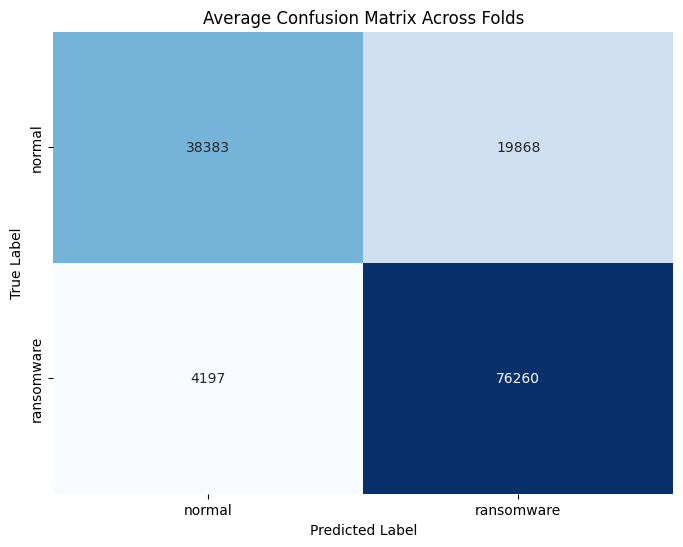


Classification Report for All Folds:
              precision    recall  f1-score   support

      normal       0.90      0.66      0.76     58251
  ransomware       0.79      0.95      0.86     80457

    accuracy                           0.83    138708
   macro avg       0.85      0.80      0.81    138708
weighted avg       0.84      0.83      0.82    138708



In [55]:
class_names = le.classes_

# Define TransformerModel class without default parameters
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, embed_dim, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        return self.output_layer(x)

# Fixed hyperparameters (set to default values)
input_dim = X_train_tensor.shape[1]
num_classes = len(class_names)
num_epochs = 3
k_folds = 5

# Default hyperparameter values
num_heads = 8
embed_dim = 256
dropout = 0.1
lr = 1e-3
batch_size = 32

best_avg_val_loss = float('inf')
best_params = None

model_dir = './Model/Default'
os.makedirs(model_dir, exist_ok=True)

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to collect metrics
all_labels = []
all_preds = []
fold_results = []

print(f"Using default hyperparameters: num_heads={num_heads}, embed_dim={embed_dim}, "
      f"dropout={dropout}, lr={lr}, batch_size={batch_size}")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_tensor)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create data loaders for the current fold
    train_dataset = TensorDataset(X_train_tensor[train_index], y_train_tensor[train_index])
    val_dataset = TensorDataset(X_train_tensor[val_index], y_train_tensor[val_index])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, criterion, and optimizer
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes,
                             num_heads=num_heads, embed_dim=embed_dim, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_metrics = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        fold_labels = []
        fold_preds = []

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                val_loss = criterion(val_outputs, y_val_batch)
                total_val_loss += val_loss.item()

                # Collect predictions and labels
                _, preds = torch.max(val_outputs, 1)
                fold_labels.extend(y_val_batch.cpu().numpy())
                fold_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = accuracy_score(fold_labels, fold_preds) * 100  # Convert to percentage
        f1 = f1_score(fold_labels, fold_preds, average='weighted')

        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_metrics = (avg_train_loss, avg_val_loss, accuracy, f1)
            # Save the best model
            print(f"Saved best model for fold {fold + 1} at epoch {epoch + 1}.")
            model_path = os.path.join(model_dir, f"best_model_fold_{fold + 1}.pth")
            torch.save(model.state_dict(), model_path)

    fold_results.append(best_metrics)
    all_labels.extend(fold_labels)
    all_preds.extend(fold_preds)

# Print K-Fold Cross-Validation Results for each fold
print(f"\nK-Fold Cross-Validation Results:")
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1} - Training Loss: {result[0]:.4f}, Validation Loss: {result[1]:.4f}, "
          f"Accuracy: {result[2]:.2f}%, F1 Score: {result[3]:.4f}")

# Calculate average metrics across folds
avg_train_loss = np.mean([result[0] for result in fold_results])
avg_val_loss = np.mean([result[1] for result in fold_results])
avg_accuracy = np.mean([result[2] for result in fold_results])
avg_f1 = np.mean([result[3] for result in fold_results])

print('-----------------------------------------------------------------------------------------')
print("\nAverage Metrics:")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

# Average Confusion Matrix
average_conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

# Classification report for all folds
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, target_names=class_names))

## **Find the best Tuning**

#### Kemudian menggunakan ParameterGrid untuk mencari dan mengevaluasi Parameter terbaik

In [56]:
from sklearn.model_selection import ParameterGrid

# Model definition without default parameters
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, embed_dim, dropout):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_dim, embed_dim)

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.output_layer = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Transform input to embeddings
        x = self.embedding(x)

        # Apply transformer encoder
        x = self.transformer_encoder(x)

        # Dropout before fully connected layer
        x = self.dropout(x)

        # Output layer (final classification)
        return self.output_layer(x)

class_names = le.classes_

# Hyperparameters grid
param_grid = {
    'num_heads': [4, 8, 16],
    'embed_dim': [128, 256, 512],
    'dropout': [0.1],
    'lr': [1e-3],
    'batch_size': [32]
}

# Fixed hyperparameters
input_dim = X_train_tensor.shape[1]
num_classes = len(class_names)
num_epochs = 3
k_folds = 5

best_avg_val_loss = float('inf')
best_params = None

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for params in ParameterGrid(param_grid):
    print(f"Evaluating params: {params}")
    
    fold_results = []
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_tensor)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Create data loaders for the current fold
        train_dataset = TensorDataset(X_train_tensor[train_index], y_train_tensor[train_index])
        val_dataset = TensorDataset(X_train_tensor[val_index], y_train_tensor[val_index])

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

        # Initialize the model, criterion, and optimizer
        model = TransformerModel(input_dim=input_dim, num_classes=num_classes,
                                 num_heads=params['num_heads'], embed_dim=params['embed_dim'], dropout=params['dropout']).to(device)  
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

        best_val_loss = float('inf')
        best_metrics = None

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            
            # Validation loop
            model.eval()
            total_val_loss = 0
            all_preds = []
            all_labels = []

            with torch.no_grad():
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)  
                    val_outputs = model(X_val_batch)
                    val_loss = criterion(val_outputs, y_val_batch)
                    total_val_loss += val_loss.item()

                    # Collect predictions and labels for metrics
                    _, preds = torch.max(val_outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(y_val_batch.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_loader)
            accuracy = accuracy_score(all_labels, all_preds) * 100  # Convert to percentage
            f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
                  f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

            # Save the best model based on validation loss
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_metrics = (avg_train_loss, avg_val_loss, accuracy, f1)

        fold_results.append(best_metrics)

    avg_train_loss = np.mean([result[0] for result in fold_results])
    avg_val_loss = np.mean([result[1] for result in fold_results])
    avg_accuracy = np.mean([result[2] for result in fold_results])
    avg_f1 = np.mean([result[3] for result in fold_results])

    print(f"\nK-Fold Cross-Validation Results:")
    print(f"Avg Training Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}, "
          f"Avg Accuracy: {avg_accuracy:.2f}%, Avg F1 Score: {avg_f1:.4f}")
    print('--------------------------------------------------------------------------------------------------')

    if avg_val_loss < best_avg_val_loss:
        best_avg_val_loss = avg_val_loss
        best_params = params

print(f"\nResult:")
print(f"\nBest hyperparameters: {best_params}")
print(f"Best average validation loss: {best_avg_val_loss:.4f}")

Evaluating params: {'batch_size': 32, 'dropout': 0.1, 'embed_dim': 128, 'lr': 0.001, 'num_heads': 4}
Fold 1/5
Epoch 1/3: Training Loss: 0.0293, Validation Loss: 0.0716, Accuracy: 98.30%, F1 Score: 0.9830
Epoch 2/3: Training Loss: 0.1835, Validation Loss: 0.0472, Accuracy: 98.88%, F1 Score: 0.9888
Epoch 3/3: Training Loss: 0.0649, Validation Loss: 0.1867, Accuracy: 94.38%, F1 Score: 0.9431
Fold 2/5
Epoch 1/3: Training Loss: 0.0421, Validation Loss: 0.0465, Accuracy: 98.92%, F1 Score: 0.9891
Epoch 2/3: Training Loss: 0.0469, Validation Loss: 0.0212, Accuracy: 99.38%, F1 Score: 0.9938
Epoch 3/3: Training Loss: 0.0430, Validation Loss: 0.0489, Accuracy: 98.98%, F1 Score: 0.9898
Fold 3/5
Epoch 1/3: Training Loss: 0.0442, Validation Loss: 0.0948, Accuracy: 98.67%, F1 Score: 0.9868
Epoch 2/3: Training Loss: 0.1763, Validation Loss: 0.0871, Accuracy: 98.27%, F1 Score: 0.9827
Epoch 3/3: Training Loss: 0.5729, Validation Loss: 0.6121, Accuracy: 69.06%, F1 Score: 0.6535
Fold 4/5
Epoch 1/3: Traini

### Simpan Hyperparameters Terbaik

In [57]:
# Save best hyperparameters to a text file
output_folder = './Hyperparameters'
os.makedirs(output_folder, exist_ok=True)
output_file_path = os.path.join(output_folder, 'best_hyperparameters.txt')

with open(output_file_path, 'w') as output_file:
    output_file.write(f"Best hyperparameters: {best_params}\n")

 ## **Classification with Tuning (Best Hyperparameters)**

#### Kemudian membuat model dengan Hyperparameters terbaik dan disimpan ke dalam Folder ./Model/Best

In [58]:
class_names = le.classes_

# Define TransformerModel class without default parameters
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads, embed_dim, dropout):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = self.dropout(x)
        return self.output_layer(x)

# Fixed hyperparameters (set to default values)
input_dim = X_train_tensor.shape[1]
num_classes = len(class_names)
num_epochs = 10
k_folds = 5

# Default hyperparameter values
num_heads = 16
embed_dim = 128
dropout = 0.1
lr = 1e-3
batch_size = 32

best_avg_val_loss = float('inf')
best_params = None

model_dir = './Model/Best'
os.makedirs(model_dir, exist_ok=True)

# K-Fold Cross-Validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to collect metrics
all_labels = []
all_preds = []
fold_results = []

print(f"Using Best Hyperparameters: batch_size={batch_size}, dropout={dropout}, lr={lr} "
      f"embed_dim={embed_dim}, num_heads={num_heads}")

for fold, (train_index, val_index) in enumerate(kf.split(X_train_tensor)):
    print(f"Fold {fold + 1}/{k_folds}")

    # Create data loaders for the current fold
    train_dataset = TensorDataset(X_train_tensor[train_index], y_train_tensor[train_index])
    val_dataset = TensorDataset(X_train_tensor[val_index], y_train_tensor[val_index])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, criterion, and optimizer
    model = TransformerModel(input_dim=input_dim, num_classes=num_classes,
                             num_heads=num_heads, embed_dim=embed_dim, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_metrics = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation loop
        model.eval()
        total_val_loss = 0
        fold_labels = []
        fold_preds = []

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                val_loss = criterion(val_outputs, y_val_batch)
                total_val_loss += val_loss.item()

                # Collect predictions and labels
                _, preds = torch.max(val_outputs, 1)
                fold_labels.extend(y_val_batch.cpu().numpy())
                fold_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = accuracy_score(fold_labels, fold_preds) * 100  # Convert to percentage
        f1 = f1_score(fold_labels, fold_preds, average='weighted')

        print(f"Epoch {epoch + 1}/{num_epochs}: Training Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_metrics = (avg_train_loss, avg_val_loss, accuracy, f1)
            # Save the best model
            print(f"Saved best model for fold {fold + 1} at epoch {epoch + 1}.")
            model_path = os.path.join(model_dir, f"best_model_fold_{fold + 1}.pth")
            torch.save(model.state_dict(), model_path)

    fold_results.append(best_metrics)
    all_labels.extend(fold_labels)
    all_preds.extend(fold_preds)

# Print K-Fold Cross-Validation Results for each fold
print(f"\nK-Fold Cross-Validation Results:")
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1} - Training Loss: {result[0]:.4f}, Validation Loss: {result[1]:.4f}, "
          f"Accuracy: {result[2]:.2f}%, F1 Score: {result[3]:.4f}")

# Calculate average metrics across folds
avg_train_loss = np.mean([result[0] for result in fold_results])
avg_val_loss = np.mean([result[1] for result in fold_results])
avg_accuracy = np.mean([result[2] for result in fold_results])
avg_f1 = np.mean([result[3] for result in fold_results])

print('-----------------------------------------------------------------------------------------')
print("\nAverage Metrics:")
print(f"Average Training Loss: {avg_train_loss:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.2f}%")
print(f"Average F1 Score: {avg_f1:.4f}")

# Average Confusion Matrix
average_conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix Across Folds')
plt.show()

# Classification report for all folds
print("\nClassification Report for All Folds:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Using default hyperparameters: num_heads=16, embed_dim=128, dropout=0.1, lr=0.001, batch_size=32
Fold 1/5
Epoch 1/10: Training Loss: 0.0444, Validation Loss: 0.0154, Accuracy: 99.55%, F1 Score: 0.9955
Saved best model for fold 1 at epoch 1.
Epoch 2/10: Training Loss: 0.0398, Validation Loss: 0.0346, Accuracy: 99.01%, F1 Score: 0.9900
Epoch 3/10: Training Loss: 0.0368, Validation Loss: 0.0327, Accuracy: 99.39%, F1 Score: 0.9939
Epoch 4/10: Training Loss: 0.0315, Validation Loss: 0.0221, Accuracy: 99.48%, F1 Score: 0.9948
Epoch 5/10: Training Loss: 0.0278, Validation Loss: 0.0196, Accuracy: 99.19%, F1 Score: 0.9919
Epoch 6/10: Training Loss: 0.0376, Validation Loss: 0.0209, Accuracy: 99.43%, F1 Score: 0.9943
Epoch 7/10: Training Loss: 0.0259, Validation Loss: 0.0202, Accuracy: 99.50%, F1 Score: 0.9950
Epoch 8/10: Training Loss: 0.0203, Validation Loss: 0.0117, Accuracy: 99.66%, F1 Score: 0.9966
Saved best model for fold 1 at epoch 8.
Epoch 9/10: Training Loss: 0.0263, Validation Loss: 0.

KeyboardInterrupt: 